In [1]:
%matplotlib inline

In [2]:
from functools import partial
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pendulum

In [3]:
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t = np.linspace(0, 100, num=20, dtype=np.float32)

In [4]:
@partial(jax.jit, backend='cpu')
def sample_trajctory_by_g(g):
    return pendulum.solve_analytical(x0, t, g=g)

In [5]:
observed_trajectory = sample_trajctory_by_g(10)

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [6]:
observed_trajectory_2 = sample_trajctory_by_g(np.float32(10.0))

In [16]:
# A fun question. Would it be faster to vectorze it internally manually?
g_grid = jnp.linspace(9, 11, num=3, dtype=np.float32)
all_trajectories_vmap = jax.vmap(sample_trajctory_by_g)(g_grid)
all_trajectories_map = np.array([sample_trajctory_by_g(g) for g in g_grid])

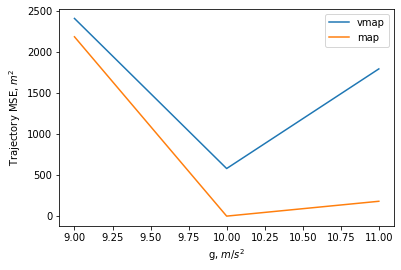

In [18]:
fig, ax = plt.subplots()
ax.plot(g_grid, ((all_trajectories_vmap - observed_trajectory)**2).mean(axis=(1,2)), label="vmap")
ax.plot(g_grid, ((all_trajectories_map - observed_trajectory)**2).mean(axis=(1,2)), label="map")
ax.set_xlabel("g, $m/s^2$")
ax.set_ylabel("Trajectory MSE, $m^2$")
ax.legend();

In [10]:
jnp.mean((all_trajectories_vmap[1] - observed_trajectory)**2), g_grid[1]

(DeviceArray(579.95795, dtype=float32), DeviceArray(10., dtype=float32))

In [11]:
jnp.mean((all_trajectories_map[1] - observed_trajectory)**2), g_grid[1]

(DeviceArray(0., dtype=float32), DeviceArray(10., dtype=float32))

In [12]:
jnp.mean((observed_trajectory - observed_trajectory_2)**2)

DeviceArray(0., dtype=float32)